#### Here we are importing all neccesery libraries in our code ####

In [27]:

import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix
import copy
import itertools


# TASK 1

#### Here we are getting dataset file and printing all the columns to define neccesary ones  ####

In [28]:

file_path = 'opsd_raw.csv' 
df = pd.read_csv(file_path)
print('All columns:\n', df.columns)

df = df[[col for col in df.columns if col.startswith('DK') or col == 'utc_timestamp']]
print('Only Denmark columns:\n', df.columns)


All columns:
 Index(['utc_timestamp', 'DK_load_actual_entsoe_transparency',
       'DK_load_forecast_entsoe_transparency', 'DK_solar_capacity',
       'DK_solar_generation_actual', 'DK_wind_capacity',
       'DK_wind_generation_actual', 'DK_wind_offshore_capacity',
       'DK_wind_offshore_generation_actual', 'DK_wind_onshore_capacity',
       'DK_wind_onshore_generation_actual',
       'DK_1_load_actual_entsoe_transparency',
       'DK_1_load_forecast_entsoe_transparency', 'DK_1_price_day_ahead',
       'DK_1_wind_onshore_generation_actual',
       'DK_2_load_actual_entsoe_transparency',
       'DK_2_load_forecast_entsoe_transparency', 'DK_2_price_day_ahead',
       'BE_load_actual_entsoe_transparency',
       'BE_load_forecast_entsoe_transparency', 'BE_solar_generation_actual',
       'BE_wind_generation_actual', 'BE_wind_offshore_generation_actual',
       'BE_wind_onshore_generation_actual',
       'DE_load_actual_entsoe_transparency',
       'DE_load_forecast_entsoe_transparency',

#### Here we are choosing only neccesary columns, why we chose this columns is decribed in attached pdf file ####

In [29]:

needed_cols = [
    'utc_timestamp',
    'DK_load_actual_entsoe_transparency', 
    'DK_wind_generation_actual',           
    'DK_solar_generation_actual'           
]
df = df[[col for col in needed_cols if col in df.columns]] 
print('Only needed columns:\n', df.columns) 
print('Size of dataframe (rows × columns):', df.shape) #also printed a size of dataframe
print("First 5 rows of raw data:\n", df.head(5)) # to understand are we corectly extracted only neccesary features


Only needed columns:
 Index(['utc_timestamp', 'DK_load_actual_entsoe_transparency',
       'DK_wind_generation_actual', 'DK_solar_generation_actual'],
      dtype='object')
Size of dataframe (rows × columns): (50400, 4)
First 5 rows of raw data:
                utc_timestamp  DK_load_actual_entsoe_transparency  \
0  2015-01-01 00:00:00+00:00                                 NaN   
1  2015-01-01 01:00:00+00:00                             3100.02   
2  2015-01-01 02:00:00+00:00                             2980.39   
3  2015-01-01 03:00:00+00:00                             2933.49   
4  2015-01-01 04:00:00+00:00                             2941.54   

   DK_wind_generation_actual  DK_solar_generation_actual  
0                        NaN                         NaN  
1                    2357.33                         NaN  
2                    2387.35                         NaN  
3                    2594.47                         NaN  
4                    3092.01                     

#### Now we are deciding what to do with missing data ####

In [30]:

missing_data = df.isnull().sum()  
total_rows = len(df)
missing_percent = (missing_data / total_rows) * 100 

missing_data_info = pd.DataFrame({
    'column': missing_data.index,
    'missing_data_rows': missing_data,
    'mising_data_percentage': missing_percent
})
print(missing_data_info)


                                                                column  \
utc_timestamp                                            utc_timestamp   
DK_load_actual_entsoe_transparency  DK_load_actual_entsoe_transparency   
DK_wind_generation_actual                    DK_wind_generation_actual   
DK_solar_generation_actual                  DK_solar_generation_actual   

                                    missing_data_rows  mising_data_percentage  
utc_timestamp                                       0                0.000000  
DK_load_actual_entsoe_transparency                  2                0.003968  
DK_wind_generation_actual                           2                0.003968  
DK_solar_generation_actual                         11                0.021825  


####  We understood that amount of missing data is very small that is why we can just drop the rows with empty cells

In [31]:
df = df.dropna()

#### Here we started transforming our dataset, firstly it is needed to trainsform timestamp into season

In [32]:

df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
df = df.set_index('utc_timestamp')

daily_records = []
for date, group in df.groupby(df.index.date):
    if len(group) == 24:
        group_sorted = group.sort_index()
        hours = group_sorted.index.hour
        if list(hours) == list(range(24)):
            daily_records.append({
                'date': date,
                'load_24h': group_sorted['DK_load_actual_entsoe_transparency'].tolist(),
                'wind_24h': group_sorted['DK_wind_generation_actual'].tolist(),
                'solar_24h': group_sorted['DK_solar_generation_actual'].tolist()
            })

def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'autumn'
    else:
        return 'winter'


seasonal_records = []
for record in daily_records:
    date = pd.to_datetime(record['date'])
    season = get_season(date)
    seasonal_records.append({
        'season': season,
        'load_24h': record['load_24h'],
        'wind_24h': record['wind_24h'],
        'solar_24h': record['solar_24h']
    })

print(seasonal_records[1]) #check is it correctly transformed


{'season': 'winter', 'load_24h': [3277.54, 3116.86, 3041.39, 3015.66, 3078.47, 3322.07, 3636.03, 3888.58, 4062.27, 4177.13, 4136.56, 4073.81, 4048.1, 3986.69, 3967.88, 4337.85, 4825.59, 4751.57, 4325.66, 4048.36, 3792.96, 3570.88, 3377.74, 3186.15], 'wind_24h': [4018.64, 4039.56, 3905.82, 3714.39, 3645.2, 3574.32, 3536.79, 3444.29, 3348.15, 3197.43, 3074.95, 3052.2, 3095.71, 3032.96, 2928.7, 2850.35, 2803.28, 2797.39, 2740.46, 2765.9, 2733.93, 2775.21, 2804.52, 2766.54], 'solar_24h': [0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.06, 9.65, 45.13, 86.73, 92.07, 69.41, 39.38, 9.12, 0.07, 0.01, 0.0, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]}


#### Here we are counting the amount of day per season

In [33]:
def countseasondays(seasonal_records):
    winter, summer, spring, autumn = 0, 0, 0, 0
    for record in seasonal_records:
        season = record['season']
        if season == 'winter':
            winter+=1
        elif season == 'summer':
            summer+=1
        elif season == 'autumn':
            autumn+=1
        elif season== 'spring':
            spring+=1
    print(f'summer days: {summer}, autumn days: {autumn}, winter days: {winter}, spring days: {spring}')
countseasondays(seasonal_records)     


summer days: 552, autumn days: 484, winter days: 510, spring days: 552


#### Here we are spliting dataset into train, validation and test parts

In [34]:


seasons = [get_season(pd.to_datetime(record['date'])) for season in seasonal_records]

train_records, test_val_records = train_test_split(
    seasonal_records,
    test_size=0.3,
    random_state=42,
    stratify=seasons 
)

test_val_seasons = [get_season(pd.to_datetime(record['date'])) for season in test_val_records]
test_records, val_records = train_test_split(
    test_val_records,
    test_size=0.5,
    random_state=42,
    stratify=test_val_seasons
)



#### Here we are plotting data to analize features to choose best validators and also plotting random days of each season

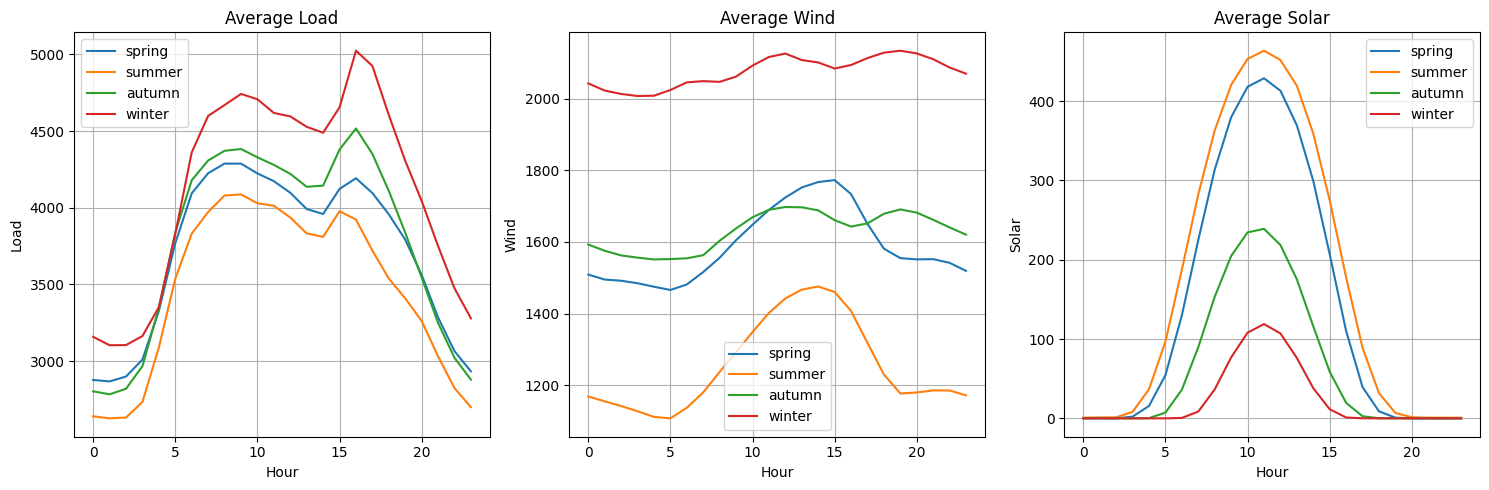

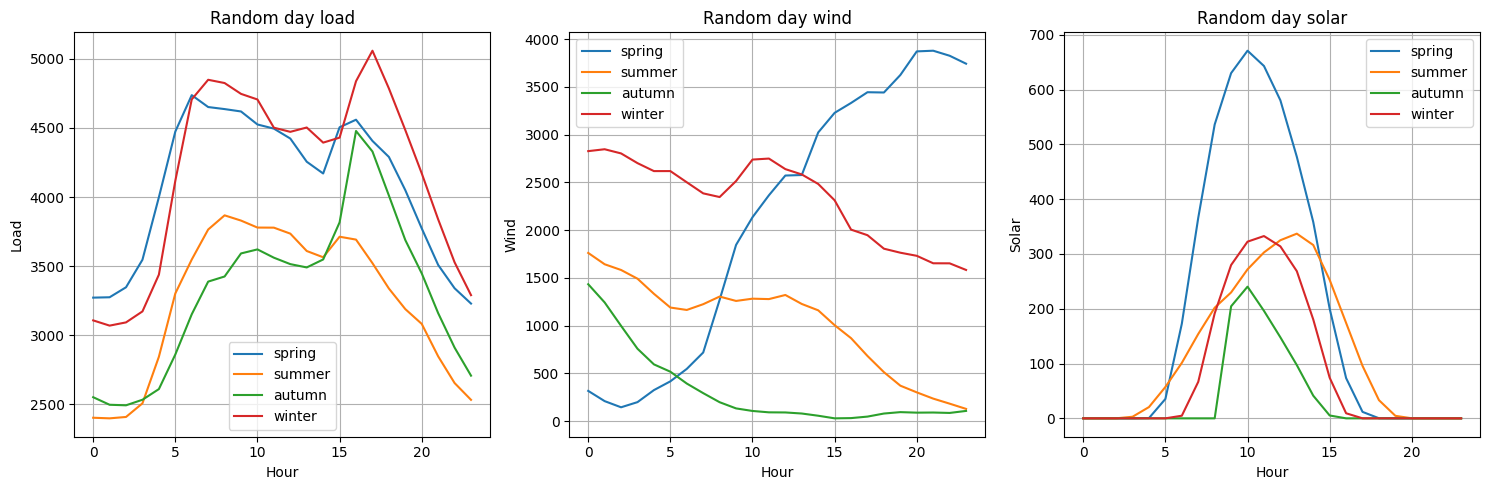

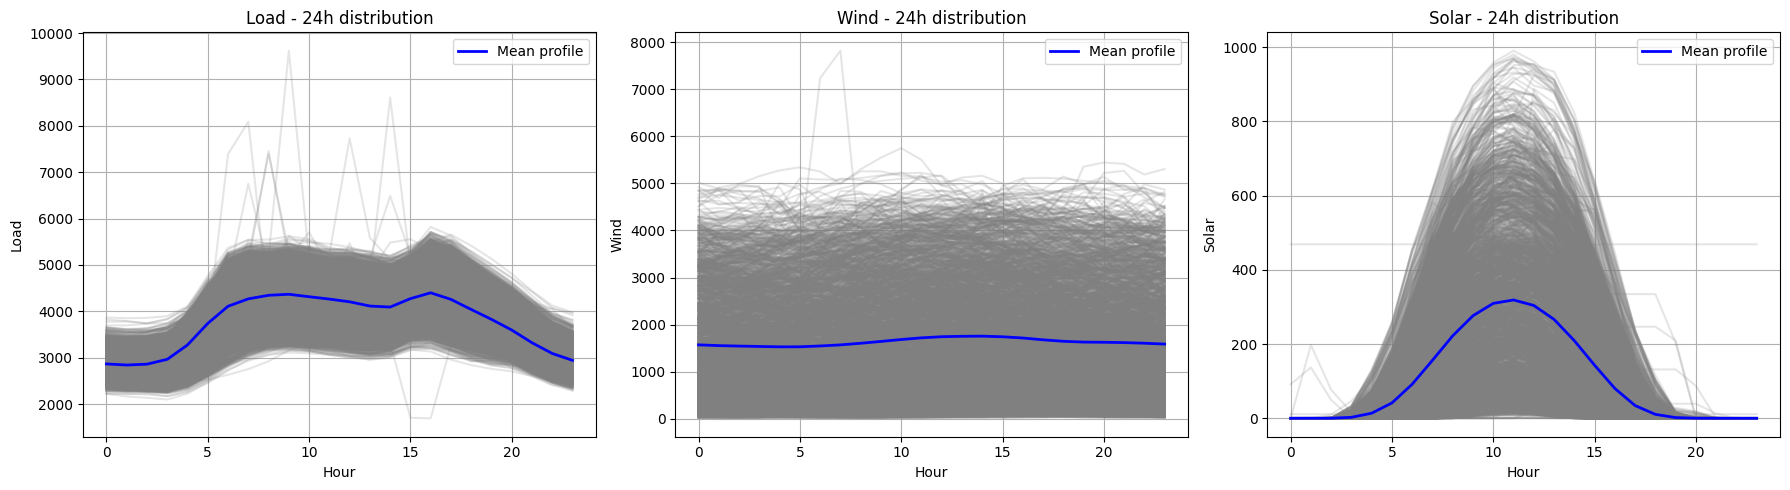

In [35]:

def plot_average_and_random_days(seasonal_records):
    seasonal_data = {
        'spring': {'load': [], 'wind': [], 'solar': []},
        'summer': {'load': [], 'wind': [], 'solar': []},
        'autumn': {'load': [], 'wind': [], 'solar': []},
        'winter': {'load': [], 'wind': [], 'solar': []}
    }

    for record in seasonal_records:
        season = record['season']
        seasonal_data[season]['load'].append(record['load_24h'])
        seasonal_data[season]['wind'].append(record['wind_24h'])
        seasonal_data[season]['solar'].append(record['solar_24h'])

    average_day_per_season = {}
    for season in seasonal_data:
        average_day_per_season[season] = {
            'load': np.mean(seasonal_data[season]['load'], axis=0),
            'wind': np.mean(seasonal_data[season]['wind'], axis=0),
            'solar': np.mean(seasonal_data[season]['solar'], axis=0)
        }

    hours = list(range(24))

    plt.figure(figsize=(15, 5))
    for i, var in enumerate(['load', 'wind', 'solar']):
        plt.subplot(1, 3, i+1)
        for season in ['spring', 'summer', 'autumn', 'winter']:
            plt.plot(hours, average_day_per_season[season][var], label=season)
        plt.title(f'Average {var.capitalize()}')
        plt.xlabel('Hour')
        plt.ylabel(var.capitalize())
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))
    seasons = ['spring', 'summer', 'autumn', 'winter']
    random_days = {}
    
    for season in seasons:
        season_days = [r for r in seasonal_records if r['season'] == season]
        if season_days:
            random_days[season] = random.choice(season_days)
    
    for i, var in enumerate(['load_24h', 'wind_24h', 'solar_24h']):
        plt.subplot(1, 3, i+1)
        for season in seasons:
            if season in random_days:
                plt.plot(hours, random_days[season][var], label=season)
        plt.title(f'Random day {var.split("_")[0]}')
        plt.xlabel('Hour')
        plt.ylabel(var.split("_")[0].capitalize())
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_average_and_random_days(seasonal_records)


def plot_feature_distribution_over_days(df):
    """
    Plots time series for 'load_24h', 'wind_24h', and 'solar_24h' over all days.
    Each subplot shows how the feature varies across all available days.
    """

    if not isinstance(df, list):
        raise ValueError("Expected df as a list of dictionaries")

    features = ['load_24h', 'wind_24h', 'solar_24h']
    hours = list(range(24))

    plt.figure(figsize=(18, 5))

    for i, feature in enumerate(features):
        all_values = [record[feature] for record in df if feature in record]
        all_values = np.array(all_values)  # shape: (num_days, 24)

        plt.subplot(1, 3, i + 1)
        for values in all_values:
            plt.plot(hours, values, alpha=0.2, color='gray')
        plt.plot(hours, np.mean(all_values, axis=0), color='blue', linewidth=2, label='Mean profile')
        plt.title(f'{feature.split("_")[0].capitalize()} - 24h distribution')
        plt.xlabel('Hour')
        plt.ylabel(feature.split("_")[0].capitalize())
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()
plot_feature_distribution_over_days(seasonal_records)

#### Analisis of first three graphs is in the attached file.  I decided to choose this 3 Scalers:
Load → StandardScaler: Load data has a relatively stable distribution with mild outliers, making standardization effective.

Wind → RobustScaler: Wind data contains high variance and outliers, so robust scaling ensures stability.

Solar → PowerTransformer: Solar generation is highly skewed with many zeros, and PowerTransformer normalizes it effectively.

#### Here we scale data to prepare it to fit into our models

In [36]:
def scale_datasets(train_data, val_data, test_data):
    combined_train = {
        'load_24h': np.concatenate([x['load_24h'] for x in train_data]),
        'wind_24h': np.concatenate([x['wind_24h'] for x in train_data]),
        'solar_24h': np.concatenate([x['solar_24h'] for x in train_data])
    }
    
    scalers = {
        'load_24h': StandardScaler().fit(combined_train['load_24h'].reshape(-1, 1)),
        'wind_24h': RobustScaler().fit(combined_train['wind_24h'].reshape(-1, 1)),
        'solar_24h': PowerTransformer().fit(combined_train['solar_24h'].reshape(-1, 1))
    }
    
    def scale_dataset(dataset):
        scaled = []
        for item in dataset:
            new_item = {'season': item['season']}
            for key in scalers:
                values = np.array(item[key]).reshape(-1, 1)
                new_item[key] = scalers[key].transform(values).flatten().tolist()
            scaled.append(new_item)
        return scaled
    
    def prepare_data_for_pca(dataset):
        data_for_pca = []
        target = []
        for record in dataset:
            features = []
            for key in ['load_24h', 'wind_24h', 'solar_24h']:
                features.extend(record[key])
            data_for_pca.append(features)
            target.append(record['season'])
        return np.array(data_for_pca), np.array(target)
    
    scaled_train = scale_dataset(train_data)
    scaled_val = scale_dataset(val_data)
    scaled_test = scale_dataset(test_data)
    
    train_data_for_pca, train_target = prepare_data_for_pca(scaled_train)
    val_data_for_pca, val_target = prepare_data_for_pca(scaled_val)
    test_data_for_pca, test_target = prepare_data_for_pca(scaled_test)

    pca = PCA(n_components=24)
    train_data_pca = pca.fit_transform(train_data_for_pca)
    val_data_pca = pca.transform(val_data_for_pca)
    test_data_pca = pca.transform(test_data_for_pca)

    return train_data_pca, val_data_pca, test_data_pca, train_target, val_target, test_target

x_train, x_val, x_test, y_train, y_val, y_test = scale_datasets(train_records, val_records, test_records)



# TASK 2

#### Here we make final preparations to fit our data in neural network

In [37]:

# 1. Data Preparation
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


#### Here we are defining neural network and using grid-search to find best parameters

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 3. Grid Search Setup
param_grid = {
    'hidden_size': [64],
    'learning_rate': [0.001]
}

num_epochs = 100
batch_size = 32

best_accuracy = 0
best_params = {}
best_model = None
training_log = []

# 4. Perform Grid Search
for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
    
    # Create DataLoaders with fixed batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = MLP(X_train_tensor.shape[1], params['hidden_size'], len(label_encoder.classes_))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    current_log = []
    
    # Training loop with fixed num_epochs
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = correct / total
        current_log.append((epoch+1, epoch_loss, val_accuracy))
    
    # Check if current model is the best
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params
        best_model = model
        training_log = current_log
        
# 5. Print Training Log for Best Model
print("\nBest Parameters Found:", best_params)

Testing params: {'hidden_size': 32, 'learning_rate': 0.001}
Testing params: {'hidden_size': 32, 'learning_rate': 0.01}
Testing params: {'hidden_size': 64, 'learning_rate': 0.001}
Testing params: {'hidden_size': 64, 'learning_rate': 0.01}
Testing params: {'hidden_size': 128, 'learning_rate': 0.001}
Testing params: {'hidden_size': 128, 'learning_rate': 0.01}

Best Parameters Found: {'hidden_size': 64, 'learning_rate': 0.001}


#### There are logs for validating our model

In [39]:
print("Epoch | Train Loss | Val Accuracy")
print("---------------------------------")
for epoch, loss, acc in training_log:
    if epoch == '...':
        print(epoch, "|", loss, "|", acc)
    else:
        print(f"{epoch:5d} | {loss:.6f} | {acc:.4f}")


Epoch | Train Loss | Val Accuracy
---------------------------------
    1 | 1.172352 | 0.5810
    2 | 0.903993 | 0.6984
    3 | 0.730173 | 0.7556
    4 | 0.603527 | 0.8095
    5 | 0.515407 | 0.8127
    6 | 0.454076 | 0.8317
    7 | 0.411940 | 0.8508
    8 | 0.381023 | 0.8603
    9 | 0.357924 | 0.8571
   10 | 0.340374 | 0.8698
   11 | 0.326292 | 0.8667
   12 | 0.315059 | 0.8762
   13 | 0.303665 | 0.8730
   14 | 0.296326 | 0.8825
   15 | 0.287876 | 0.8730
   16 | 0.283668 | 0.8762
   17 | 0.277963 | 0.8762
   18 | 0.272207 | 0.8794
   19 | 0.265731 | 0.8794
   20 | 0.261147 | 0.8825
   21 | 0.256636 | 0.8857
   22 | 0.253646 | 0.8889
   23 | 0.248240 | 0.8825
   24 | 0.245061 | 0.8889
   25 | 0.240813 | 0.8857
   26 | 0.238755 | 0.8794
   27 | 0.233257 | 0.8857
   28 | 0.230666 | 0.8857
   29 | 0.227357 | 0.8794
   30 | 0.224272 | 0.8857
   31 | 0.220401 | 0.8857
   32 | 0.217882 | 0.8825
   33 | 0.214515 | 0.8825
   34 | 0.211232 | 0.8857
   35 | 0.208510 | 0.8794
   36 | 0.205696 | 0.8

####  Ploting Training Curves for Best Model

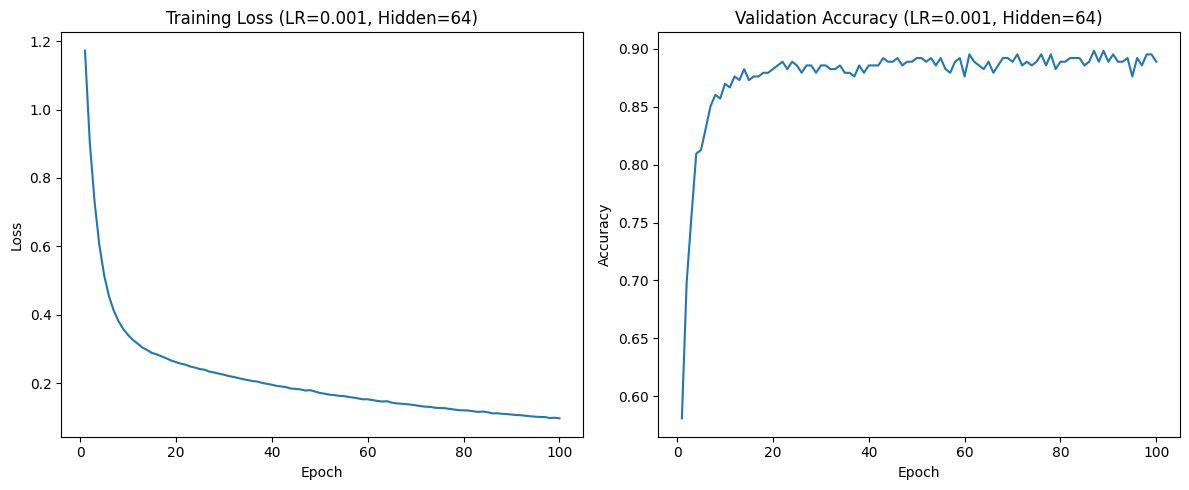

In [40]:


epochs, losses, accuracies = zip(*training_log)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.title(f'Training Loss (LR={best_params["learning_rate"]}, Hidden={best_params["hidden_size"]})')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies)
plt.title(f'Validation Accuracy (LR={best_params["learning_rate"]}, Hidden={best_params["hidden_size"]})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()


#### Final Evaluation on Test Set

In [52]:

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

best_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 24]

#### Here we are making confusion matrix

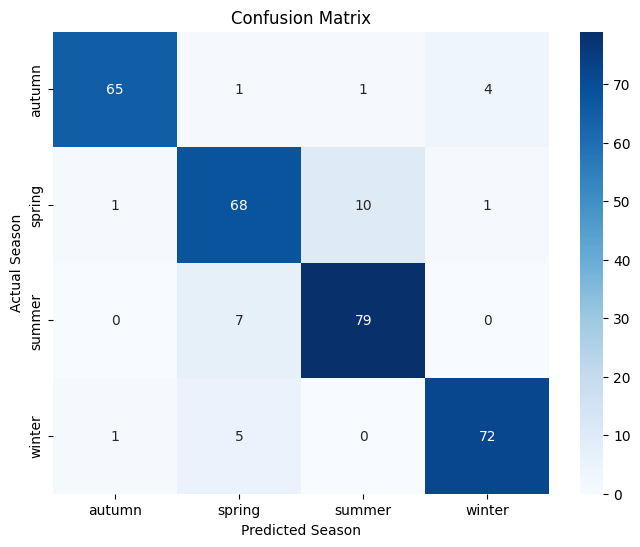

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

# Get all predictions and true labels for the test set

all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert indices back to season names if you have a label encoder
season_names = label_encoder.classes_


# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=season_names, 
            yticklabels=season_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Season')
plt.ylabel('Actual Season')
plt.show()


# TASK 3

#### Here we are preparing data to have 3 chanels, instead of one

In [43]:
def scale_datasets_no_pca(train_data, val_data, test_data):
    import numpy as np
    from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

    
    combined_train = {
        'load_24h': np.concatenate([x['load_24h'] for x in train_data]),
        'wind_24h': np.concatenate([x['wind_24h'] for x in train_data]),
        'solar_24h': np.concatenate([x['solar_24h'] for x in train_data])
    }

    scalers = {
        'load_24h': StandardScaler().fit(combined_train['load_24h'].reshape(-1, 1)),
        'wind_24h': RobustScaler().fit(combined_train['wind_24h'].reshape(-1, 1)),
        'solar_24h': PowerTransformer().fit(combined_train['solar_24h'].reshape(-1, 1))
    }

    def scale_and_stack_no_pca(dataset):
        X = []
        y = []
        for item in dataset:
            load = scalers['load_24h'].transform(np.array(item['load_24h']).reshape(-1, 1)).flatten()
            wind = scalers['wind_24h'].transform(np.array(item['wind_24h']).reshape(-1, 1)).flatten()
            solar = scalers['solar_24h'].transform(np.array(item['solar_24h']).reshape(-1, 1)).flatten()
            
            sample = np.stack([load, wind, solar], axis=0)
            X.append(sample)
            y.append(item['season'])
        
        return np.array(X), np.array(y)

    X_train, y_train = scale_and_stack_no_pca(train_data)
    X_val, y_val = scale_and_stack_no_pca(val_data)
    X_test, y_test = scale_and_stack_no_pca(test_data)

    return X_train, X_val, X_test, y_train, y_val, y_test

x_train_no_pca, x_val_no_pca, x_test_no_pca, y_train, y_val, y_test = scale_datasets_no_pca(
    train_records, val_records, test_records
)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)


X_train_tensor_no_pca = torch.tensor(x_train_no_pca, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_val_tensor_no_pca = torch.tensor(x_val_no_pca, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)
X_test_tensor_no_pca = torch.tensor(x_test_no_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

train_dataset_no_pca = TensorDataset(X_train_tensor_no_pca, y_train_tensor)
val_dataset_no_pca = TensorDataset(X_val_tensor_no_pca, y_val_tensor)
test_dataset_no_pca = TensorDataset(X_test_tensor_no_pca, y_test_tensor)


In [44]:
class SeasonCNN(nn.Module):
    def __init__(self, input_channels=3, seq_len=24, num_classes=4, kernel_size=3, dropout=0.2):
        super(SeasonCNN, self).__init__()
        
        # Convolutional Block 1:
        # Input: (batch_size, 3, 24)
        # Conv1d: transforms 3 channels to 32 while preserving the sequence length
        # Output after conv1: (batch_size, 32, 24)
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size, padding=1)
        self.relu1 = nn.ReLU()
        # MaxPool1d with kernel_size=2 halves the sequence length:
        # (batch_size, 32, 24) -> (batch_size, 32, 12)
        self.pool1 = nn.MaxPool1d(2)
        # BatchNorm1d normalizes across the channels without changing shape:
        # (batch_size, 32, 12) -> (batch_size, 32, 12)
        self.bn1 = nn.BatchNorm1d(32)
        
        # Convolutional Block 2:
        # Input: (batch_size, 32, 12)
        # Conv1d: transforms 32 channels to 64 while preserving the sequence length:
        # (batch_size, 32, 12) -> (batch_size, 64, 12)
        self.conv2 = nn.Conv1d(32, 64, kernel_size, padding=1)
        self.relu2 = nn.ReLU()
        # MaxPool1d: halves the sequence length:
        # (batch_size, 64, 12) -> (batch_size, 64, 6)
        self.pool2 = nn.MaxPool1d(2)
        # BatchNorm1d preserves shape:
        # (batch_size, 64, 6) -> (batch_size, 64, 6)
        self.bn2 = nn.BatchNorm1d(64)
        
        # Dropout for regularization, shape remains unchanged:
        # (batch_size, 64, 6) -> (batch_size, 64, 6)
        self.dropout = nn.Dropout(dropout)
        
        # Calculate the input size for the fully connected layer.
        # The calculate_fc_input function simulates a pass with a dummy input and returns the number of features.
        # For input (batch_size, 3, 24), the expected output is (batch_size, 64, 6) which is flattened to (batch_size, 64*6)= (batch_size, 384)
        self.fc_input = self.calculate_fc_input(seq_len, kernel_size)
        
        # Fully connected layers:
        # First fully connected layer:
        # (batch_size, 384) -> (batch_size, 128)
        self.fc1 = nn.Linear(self.fc_input, 128)
        self.relu3 = nn.ReLU()
        # Second fully connected layer for classification:
        # (batch_size, 128) -> (batch_size, 4)
        self.fc2 = nn.Linear(128, num_classes)
        
    def calculate_fc_input(self, seq_len, kernel_size):
        # Simulate the input tensor with 3 channels
        x = torch.randn(1, 3, seq_len)  # (batch_size=1, channels=3, seq_len=24)
        
        # Pass through all layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.bn1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        
        return x.numel()  # 64*6 = 384 elements
        
    def forward(self, x):
        # Transform input if needed
        if len(x.shape) == 2:  # if (batch_size, seq_len)
            x = x.unsqueeze(1)  # add channel dimension -> (batch_size, 1, seq_len)
        elif len(x.shape) == 3 and x.shape[1] != 3:  # if channels are not in the second position
            x = x.permute(0, 2, 1)  # swap axes -> (batch_size, channels, seq_len)
        
        # Forward pass through layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.bn1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu3(x)
        return self.fc2(x)


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return total_loss / len(loader), correct / total

def train(model, train_loader, val_loader, criterion, optimizer, epochs, patience=5):
    best_val_acc = 0.0
    best_model = None
    patience_counter = 0
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    model.load_state_dict(best_model)
    return model, train_losses, val_losses, train_accs, val_accs


# Parameters for Grid Search
param_grid = {
    'kernel_size': [3, 5],
    'dropout': [0.5, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32]
}

best_cnn = {'acc': 0, 'model': None, 'params': None}
epochs = 100

train_loader = DataLoader(train_dataset_no_pca, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_no_pca, batch_size=32)
test_loader = DataLoader(test_dataset_no_pca, batch_size=32)

# Grid search
for params in ParameterGrid(param_grid):
    print(f"\nTesting {params}")
    
    # Create model
    model = SeasonCNN(kernel_size=params['kernel_size'], 
                     dropout=params['dropout'])
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.CrossEntropyLoss()
    
    # Train model
    model, train_losses, val_losses, train_accs, val_accs = train(
        model, train_loader, val_loader, criterion, optimizer, epochs)
    
    # Save the best model
    current_best_val_acc = max(val_accs)  
    if current_best_val_acc > best_cnn['acc']:
        best_cnn['acc'] = current_best_val_acc
        best_cnn['model'] = model
        best_cnn['params'] = params
        best_cnn['train_losses'] = train_losses
        best_cnn['val_losses'] = val_losses
        best_cnn['train_accs'] = train_accs
        best_cnn['val_accs'] = val_accs

# Evaluate on the test set
test_loader = DataLoader(test_dataset_no_pca, batch_size=best_cnn['params']['batch_size'])
test_loss, test_acc = evaluate(best_cnn['model'], test_loader, criterion)
print(f"\nBest Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")
print(f"Best Params: {best_cnn['params']}")



Testing {'batch_size': 32, 'dropout': 0.5, 'kernel_size': 3, 'learning_rate': 0.001}
Epoch 1/100 - Train Loss: 0.7993, Train Acc: 0.6301 - Val Loss: 0.6174, Val Acc: 0.7524
Epoch 2/100 - Train Loss: 0.5786, Train Acc: 0.7411 - Val Loss: 0.4402, Val Acc: 0.8349
Epoch 3/100 - Train Loss: 0.4781, Train Acc: 0.7997 - Val Loss: 0.4297, Val Acc: 0.8159
Epoch 4/100 - Train Loss: 0.4353, Train Acc: 0.8134 - Val Loss: 0.3666, Val Acc: 0.8444
Epoch 5/100 - Train Loss: 0.4050, Train Acc: 0.8256 - Val Loss: 0.3709, Val Acc: 0.8508
Epoch 6/100 - Train Loss: 0.3817, Train Acc: 0.8372 - Val Loss: 0.3584, Val Acc: 0.8413
Epoch 7/100 - Train Loss: 0.3592, Train Acc: 0.8508 - Val Loss: 0.3674, Val Acc: 0.8540
Epoch 8/100 - Train Loss: 0.3416, Train Acc: 0.8542 - Val Loss: 0.3756, Val Acc: 0.8603
Epoch 9/100 - Train Loss: 0.3332, Train Acc: 0.8685 - Val Loss: 0.3412, Val Acc: 0.8730
Epoch 10/100 - Train Loss: 0.3132, Train Acc: 0.8678 - Val Loss: 0.3224, Val Acc: 0.8508
Epoch 11/100 - Train Loss: 0.2875

#### Here we are plotting curves

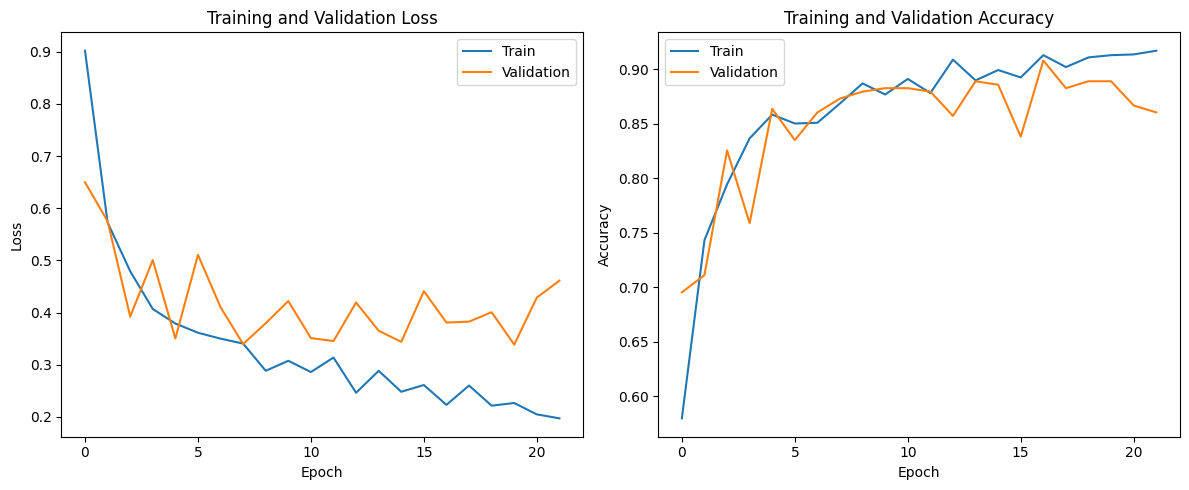

In [45]:

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(best_cnn['train_losses'], best_cnn['val_losses'],
                     best_cnn['train_accs'], best_cnn['val_accs'])


#### Here we are making confusion matrix

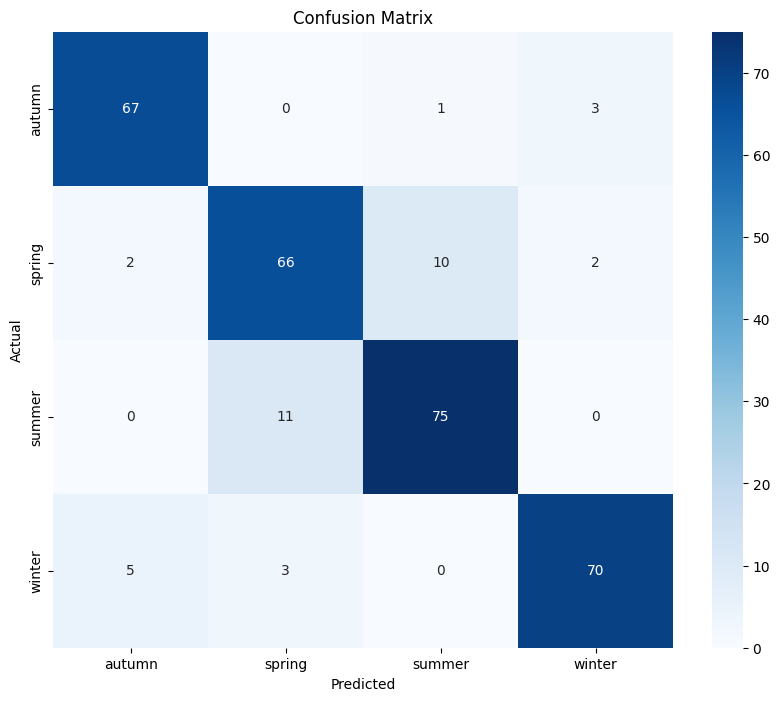

In [46]:
def plot_confusion_matrix(model, loader, label_encoder):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(best_cnn['model'], test_loader, label_encoder)

# TASK 4


#### Data Preparation and Scaling

In [47]:


def scale_datasets(train_data, val_data, test_data):
    combined = {
        'load': np.concatenate([x['load_24h'] for x in train_data]),
        'wind': np.concatenate([x['wind_24h'] for x in train_data]),
        'solar': np.concatenate([x['solar_24h'] for x in train_data])
    }

    scalers = {
        'load': StandardScaler().fit(combined['load'].reshape(-1, 1)),
        'wind': RobustScaler().fit(combined['wind'].reshape(-1, 1)),
        'solar': PowerTransformer().fit(combined['solar'].reshape(-1, 1))
    }

    def scale_and_reshape(data):
        X, y = [], []
        for item in data:
            load = scalers['load'].transform(np.array(item['load_24h']).reshape(-1, 1)).flatten()
            wind = scalers['wind'].transform(np.array(item['wind_24h']).reshape(-1, 1)).flatten()
            solar = scalers['solar'].transform(np.array(item['solar_24h']).reshape(-1, 1)).flatten()
            
            # Transform each 24-hour time-series into a 6x4 matrix (Option B)
            sample = np.stack([
                load.reshape(6, 4),
                wind.reshape(6, 4),
                solar.reshape(6, 4)
            ], axis=0)
            
            X.append(sample)
            y.append(item['season'])
        return np.array(X, dtype=np.float32), np.array(y)

    X_train, y_train = scale_and_reshape(train_data)
    X_val, y_val = scale_and_reshape(val_data)
    X_test, y_test = scale_and_reshape(test_data)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


#### Model Architecture

In [48]:


class CNN2D(nn.Module):
    def __init__(self, num_classes=4, base_channels=32, kernel_size=3, dropout=0.3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, base_channels, kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(base_channels, base_channels*2, kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(base_channels*2, base_channels*4, kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_channels*4, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


#### Training Function with Logging

In [49]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device,
                epochs=50, early_stopping_patience=10, min_delta=1e-4):
    best_acc = 0.0
    best_weights = None
    training_log = []
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            correct += (output.argmax(1) == y).sum().item()
            total += y.size(0)
        train_loss /= total
        train_acc = correct / total

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = criterion(output, y)
                val_loss += loss.item() * x.size(0)
                correct += (output.argmax(1) == y).sum().item()
                total += y.size(0)
        val_loss /= total
        val_acc = correct / total

        training_log.append((epoch + 1, train_loss, train_acc, val_loss, val_acc))
        print(f"Epoch {epoch + 1}: Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")

        if val_acc > best_acc + min_delta:
            best_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

    model.load_state_dict(best_weights)
    return best_acc, training_log

# 4. Grid Search
def grid_search(train_loader, val_loader, device, batch_size):
    param_grid = {
        'lr': [0.001, 0.0005],
        'base_channels': [32],
        'kernel_size': [3, 5],
        'dropout': [0.2]
    }

    results = []
    best_acc = 0
    best_params = {}
    best_log = None

    for lr, base_channels, kernel_size, dropout in itertools.product(*param_grid.values()):
        print(f"\nTesting config: LR={lr}, Channels={base_channels}, Kernel={kernel_size}, Dropout={dropout}")
        model = CNN2D(base_channels=base_channels, kernel_size=kernel_size, dropout=dropout).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        acc, log = train_model(model, train_loader, val_loader, optimizer,
                               nn.CrossEntropyLoss(), device)
        results.append({
            'lr': lr,
            'base_channels': base_channels,
            'kernel_size': kernel_size,
            'dropout': dropout,
            'val_acc': acc
        })

        if acc > best_acc:
            best_acc = acc
            best_params = {
                'learning_rate': lr,
                'base_channels': base_channels,
                'kernel_size': kernel_size,
                'dropout': dropout,
                'batch_size': batch_size
            }
            best_log = log
            torch.save(model.state_dict(), 'best_model.pth')

    return pd.DataFrame(results), best_params, best_log


#### Evaluation and plotting confusion matrix


Testing config: LR=0.001, Channels=32, Kernel=3, Dropout=0.2
Epoch 1: Train Loss 0.7424 Acc 0.6880 | Val Loss 0.5942 Acc 0.7714
Epoch 2: Train Loss 0.4511 Acc 0.8195 | Val Loss 0.4698 Acc 0.8190
Epoch 3: Train Loss 0.4331 Acc 0.8263 | Val Loss 0.3732 Acc 0.8540
Epoch 4: Train Loss 0.3386 Acc 0.8747 | Val Loss 0.3922 Acc 0.8508
Epoch 5: Train Loss 0.3205 Acc 0.8753 | Val Loss 0.3240 Acc 0.8635
Epoch 6: Train Loss 0.3185 Acc 0.8781 | Val Loss 0.3967 Acc 0.8286
Epoch 7: Train Loss 0.3111 Acc 0.8808 | Val Loss 0.3317 Acc 0.8667
Epoch 8: Train Loss 0.2866 Acc 0.8903 | Val Loss 0.3456 Acc 0.8698
Epoch 9: Train Loss 0.2588 Acc 0.9053 | Val Loss 0.3632 Acc 0.8413
Epoch 10: Train Loss 0.2591 Acc 0.8992 | Val Loss 0.3063 Acc 0.8857
Epoch 11: Train Loss 0.2203 Acc 0.9162 | Val Loss 0.3526 Acc 0.8730
Epoch 12: Train Loss 0.2401 Acc 0.9067 | Val Loss 0.2956 Acc 0.8889
Epoch 13: Train Loss 0.2062 Acc 0.9162 | Val Loss 0.2985 Acc 0.8921
Epoch 14: Train Loss 0.2409 Acc 0.9087 | Val Loss 0.3802 Acc 0.

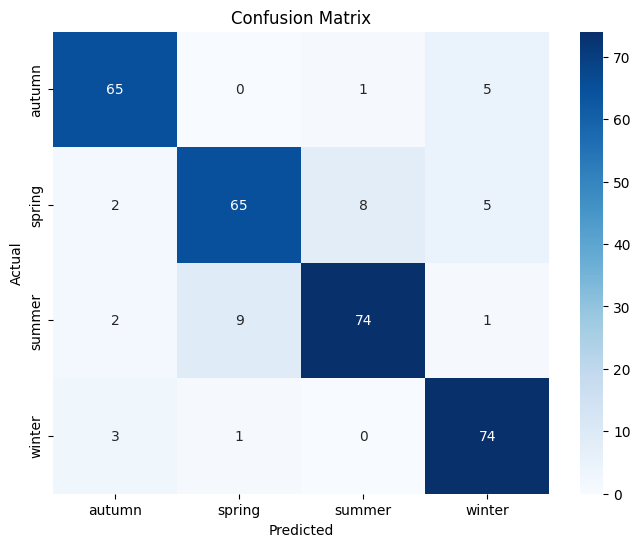

In [50]:
def evaluate_model(model, test_loader, device, label_encoder):
    model.eval()
    preds, targets = [], []
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            _, predicted = output.max(1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(y.cpu().numpy())
            correct += (predicted == y).sum().item()
            total += y.size(0)

    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")

    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



# 7. Main Execution
X_train, X_val, X_test, y_train, y_val, y_test = scale_datasets(train_records, val_records, test_records)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(y_val)), batch_size=32)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

results_df, best_params, training_log = grid_search(train_loader, val_loader, device, batch_size=32)
print("Best Params:", best_params)

# Reload and evaluate best model
best_model = CNN2D(base_channels=best_params['base_channels'],
                   kernel_size=best_params['kernel_size'],
                   dropout=best_params['dropout']).to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

evaluate_model(best_model, test_loader, device, label_encoder)



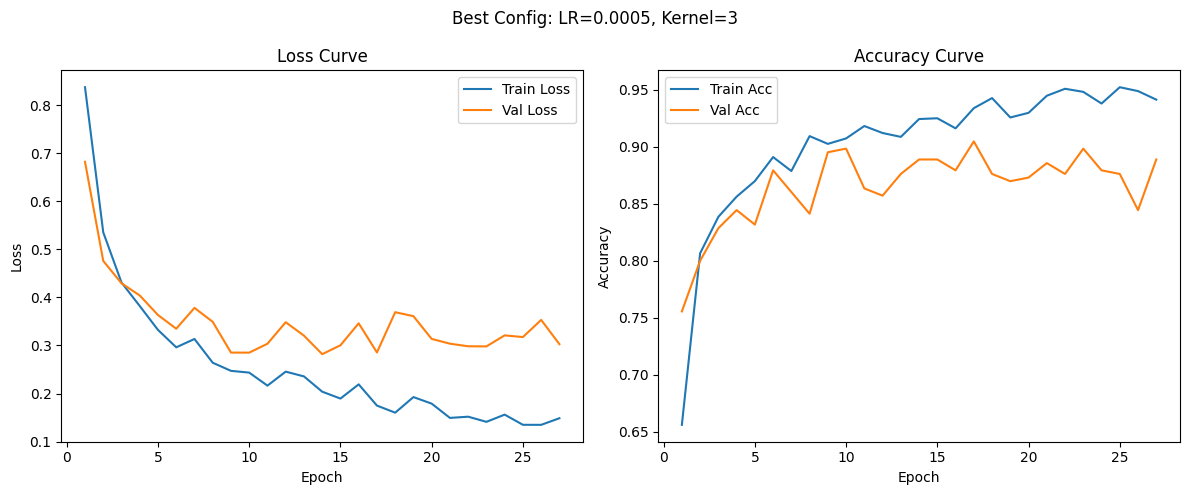

In [51]:
# 6. Plotting Function
def plot_training(training_log, best_params):
    epochs, train_losses, train_accs, val_losses, val_accs = zip(*training_log)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.suptitle(f"Best Config: LR={best_params['learning_rate']}, Kernel={best_params['kernel_size']}")
    plt.tight_layout()
    plt.show()

plot_training(training_log, best_params)